In [217]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import meshio
import pyvista as pv
import torch
from os import listdir
from os.path import isfile, join
import multiprocessing
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load wss files from the data directory
mypath = '../../data/MlgSA/wss/'
onlyfiles = np.asarray([f for f in listdir(mypath) if isfile(join(mypath, f))])
onlyfiles.sort()
print(len(onlyfiles))
short_list = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles])
#short_list.sort()
#short_list

108


In [88]:
# Load the stenosis degree file
df = pd.read_csv("../../data/MLgSA/stenosis_metadata.csv", sep=';')

In [89]:
# Matching the stenosis degree to the datasets
# missing datasets : index = [68, 87, 106]
df.iloc[[68, 87, 106]]

,ID,Stenosis Degree,Min Diameter Position,Min Diameter Normal,Ref Diameter Position,Ref Diameter Normal,Unnamed: 6
68,patient_w_030_right,27.402373,"[-29.677610397338867, -26.901166915893555, -49...","[-0.47144395112991333, -0.5586462616920471, 0....","[-21.575729370117188, -25.14781379699707, -40....","[0.6858331561088562, -0.21918608248233795, 0.6...",NaN
87,patient_w_040_right,30.443229,"[24.264554977416992, -7.138415336608887, -58.6...","[0.5276118516921997, -0.7966058254241943, 0.29...","[28.314176559448242, -13.79305648803711, -52.7...","[-0.3992733657360077, 0.25153839588165283, 0.8...",NaN
106,patient_w_051_left,6.707421,"[-31.28226089477539, 24.9633846282959, -56.382...","[0.17472846806049347, 0.11324866116046906, 0.9...","[-30.387218475341797, 26.080673217773438, -49....","[0.17472846806049347, 0.11324866116046906, 0.9...",NaN


In [90]:
# Drop missing targets
df = df.drop(index=[68, 87, 106])
degree_list = df['ID'].values
#degree_list

In [1]:
# Check to see if the order of files is a match
i = 0
for t, (a,b) in enumerate(zip(degree_list, short_list)):
    if a != b:
        i = t
        print(i)
        print(degree_list[i], short_list[i])
        print(degree_list[i] in short_list)
        break

In [1]:
# Read the corresponding mesh files
meshes = []

for f in onlyfiles:
    reader = pv.get_reader(mypath + f)
    meshes.append(reader.read())

In [1]:
def get_data(mesh_name):
    columns = ['longitudinal_WSS_@_t=1.1', 'non-directional_WSS_@_t=1.1', 'longitudinal_WSS_@_t=1.55', 'non-directional_WSS_@_t=1.55']
    node_array = mesh_name.points
    cell_array = mesh_name.cells.reshape(-1, 4)[:, 1:]
    n = node_array.shape[0]
    adjacency = np.zeros((n, n), dtype=int)
    for c in cell_array:
        adjacency[c[0], c[1]] = 1
        adjacency[c[1], c[0]] = 1
        adjacency[c[1], c[2]] = 1
        adjacency[c[2], c[1]] = 1
        adjacency[c[2], c[0]] = 1
        adjacency[c[0], c[2]] = 1

    features = np.asarray([mesh_name.point_data[columns[0]], mesh_name.point_data[columns[1]], mesh_name.point_data[columns[2]], mesh_name.point_data[columns[3]]]).T

    return torch.tensor(np.maximum(adjacency, adjacency.T), dtype=torch.float).nonzero().t(), n, torch.tensor(features, dtype=torch.float)

In [1]:
edjl = []
numl = []
nf = []

p = multiprocessing.Pool()

for j, m in enumerate(meshes):
    edj, num, fe = get_data(m)
    edjl.append(edj)
    numl.append(num)
    nf.append(fe)
    print(j)

p.close()
p.join()


data_list = [Data(x = a, edge_index=b, y = y) for (a, b, y) in zip(nf, edjl, df['Stenosis Degree'])]

torch.save(edjl, '../export/edge_indices.pt')
torch.save(numl, '../export/nodes.pt')
torch.save(nf, '../export/node_features.pt')
torch.save(data_list, '../export/dataset.pt')

In [73]:
data_list = torch.load('../export/dataset.pt')
del data_list[33]
nf = torch.load('../export/node_features.pt')
edjl = torch.load('../export/edge_indices.pt')
numl = torch.load( '../export/nodes.pt')

In [75]:
del nf[33]
del edjl[33]
del numl[33]

In [76]:
# More checks
for j, n in enumerate(numl):
    if n != data_list[j].num_nodes:
        print(j)
    if data_list[j].is_directed():
        print(j)

In [101]:
# Means and Stds

ys = [pt.y for pt in data_list]

In [84]:
# Target Variability

mean_y = np.mean([pt.y for pt in data_list])
max_y = np.max([pt.y for pt in data_list])
min_y = np.min([pt.y for pt in data_list])
std_y = np.std([pt.y for pt in data_list])

In [85]:
print(mean_y, max_y, min_y, std_y)

22.147463121686087 76.36348114970801 0.5041916488547437 19.141290252636434


(array([31., 20., 18., 10.,  8.,  7.,  3.,  1.,  5.,  4.]),
 array([ 0.50419165,  8.0901206 , 15.67604955, 23.2619785 , 30.84790745,
        38.4338364 , 46.01976535, 53.6056943 , 61.19162325, 68.7775522 ,
        76.36348115]),
 <BarContainer object of 10 artists>)

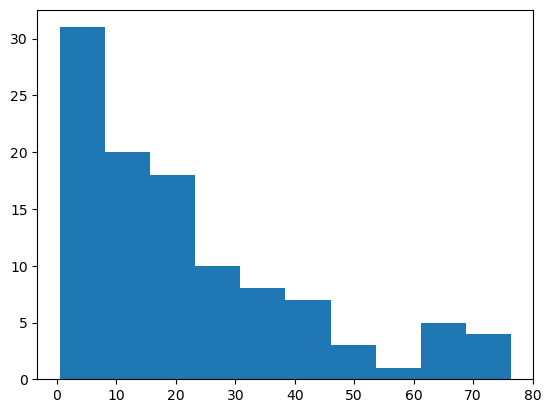

In [106]:
counts, bins = np.histogram([pt.y for pt in data_list])
plt.hist(ys)

In [104]:
print(counts, '\n', bins)

[31 20 18 10  8  7  3  1  5  4] 
 [ 0.50419165  8.0901206  15.67604955 23.2619785  30.84790745 38.4338364
 46.01976535 53.6056943  61.19162325 68.7775522  76.36348115]


(array([18., 16., 16., 20., 18., 19.]),
 array([ 0.,  5., 10., 15., 25., 40., 90.]),
 <BarContainer object of 6 artists>)

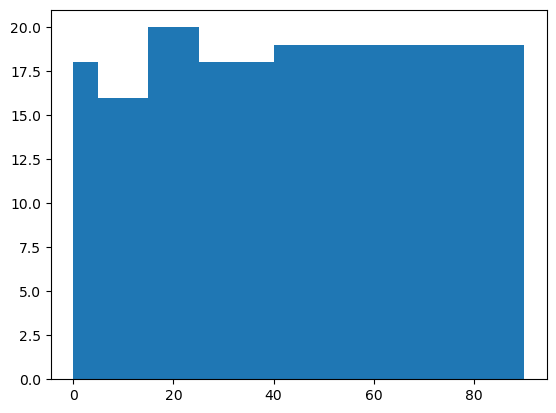

In [129]:
plt.hist(ys, bins=[0, 5, 10, 15, 25, 40, 90])

In [161]:
def F(x):
    return sum([y <= x for y in ys])/len(ys)

(array([18., 18., 18., 17., 18., 18.]),
 array([0.  , 0.17, 0.34, 0.51, 0.67, 0.84, 1.  ]),
 <BarContainer object of 6 artists>)

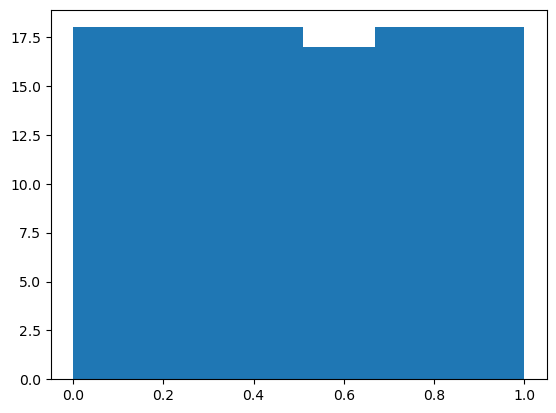

In [193]:
hat_y = [F(y) for y in ys]

plt.hist(hat_y, bins= [0.0, 0.17, 0.34, 0.51 , 0.67, 0.84, 1.])

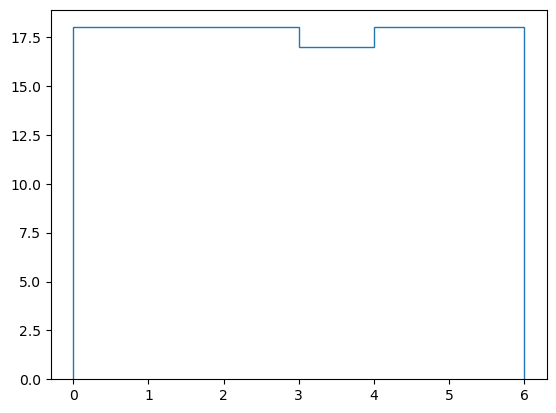

In [194]:
counts, bins =np.histogram(hat_y,bins=[0.0, 0.17, 0.34, 0.51 , 0.67, 0.84, 1.])

plt.stairs(counts)

In [204]:
dy = np.digitize(hat_y, bins, right=True) - 1

In [205]:
print((dy, ys))

(array([4, 5, 2, 0, 3, 4, 5, 1, 4, 4, 1, 3, 4, 5, 5, 0, 1, 1, 2, 3, 4, 0,
       3, 3, 4, 0, 2, 0, 0, 2, 2, 4, 2, 5, 5, 2, 2, 3, 1, 1, 4, 5, 2, 1,
       1, 1, 2, 4, 3, 3, 4, 5, 1, 3, 2, 1, 0, 3, 2, 5, 0, 5, 2, 3, 2, 0,
       4, 3, 5, 5, 0, 0, 1, 1, 4, 4, 1, 4, 4, 5, 4, 5, 3, 0, 0, 2, 1, 2,
       3, 3, 1, 2, 0, 5, 3, 5, 5, 3, 1, 2, 0, 0, 4, 0, 5, 0, 1],
      dtype=int64), [26.126666520373508, 71.55461808841325, 14.989693821100936, 3.440384067120566, 21.13145726892333, 36.81742624699327, 75.67920912829408, 10.03391473333917, 25.105676903367453, 30.584103289543624, 5.548061468416428, 22.193821413445946, 36.48818124997736, 40.43076571427493, 63.51410691643756, 2.171972995840946, 5.024651076526039, 7.078013489518377, 11.867340411825444, 22.065576366226534, 31.659627305267858, 4.093569336460916, 18.472349849726157, 17.76002255504098, 33.358993870589075, 4.5258716407333655, 11.50381182366406, 3.2261573248520152, 2.850462890845114, 11.094062870783072, 10.812626527614096, 38.4997594950185, 

In [206]:
y_classes = np.zeros((len(ys), 6))

In [207]:
for k, c in zip(y_classes, dy):
    k[c] = 1.0

In [208]:
y_classes[81]

array([0., 0., 0., 0., 0., 1.])

In [141]:
means = []
stds = []
mins = []
maxs = []

In [142]:
for t, pt in enumerate(nf):
    means.append(torch.mean(pt, axis =0))
    stds.append(torch.std(pt, axis =0))
    mins.append(torch.amin(pt, axis =0))
    maxs.append(torch.amax(pt, axis =0))

In [146]:
for m in stds:
    if np.isnan(m).any():
        print('yolo')

In [147]:
len(means)

107

In [155]:

for t, gp in enumerate(data_list):
    s = StandardScaler()
    s.fit(gp.x)
    print(gp.x)
    data_list[t].x = s.transform(gp.x)
    print(t, data_list[t].x)

[[-0.60021586 -0.72791386 -0.59051759 -0.68328535]
 [-0.6157197  -0.74364276 -0.61596402 -0.70890331]
 [-0.62540497 -0.75366467 -0.62548184 -0.71858322]
 ...
 [-0.90276345 -1.0342306  -0.69310765 -0.78668268]
 [-0.88163841 -1.01309291 -0.63184979 -0.72501378]
 [-0.91047794 -1.04226072 -0.70761969 -0.8012693 ]]
0 [[-0.60021586 -0.72791386 -0.59051759 -0.68328535]
 [-0.6157197  -0.74364276 -0.61596402 -0.70890331]
 [-0.62540497 -0.75366467 -0.62548184 -0.71858322]
 ...
 [-0.90276345 -1.0342306  -0.69310765 -0.78668268]
 [-0.88163841 -1.01309291 -0.63184979 -0.72501378]
 [-0.91047794 -1.04226072 -0.70761969 -0.8012693 ]]
[[ 0.69500691  0.59528948  0.52322715  0.42730887]
 [ 0.89796587  0.79056877  0.67872066  0.58186653]
 [ 0.66963398  0.57686128  0.51917275  0.42385596]
 ...
 [ 0.08340089 -0.0425283   0.02852    -0.06757192]
 [ 0.19999584  0.06946833  0.03544232 -0.06810604]
 [ 0.01911682 -0.11190255 -0.08743244 -0.1922421 ]]
1 [[ 0.69500691  0.59528948  0.52322715  0.42730887]
 [ 0.8979

In [228]:
# Transform targets to classes

for t in range(len(data_list)):
    data_list[t].y = torch.tensor(y_classes[t], dtype=torch.float32)

In [229]:
for t in range(len(data_list)):
    data_list[t].x = torch.tensor(data_list[t].x, dtype=torch.float32)

C:\Users\Rohit\AppData\Local\Temp\ipykernel_32688\3771077959.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_list[t].x = torch.tensor(data_list[t].x, dtype=torch.float32)


In [225]:
X_train, X_test, y_train, y_test = train_test_split(data_list, y_classes,
                                                    stratify=y_classes,
                                                    test_size=0.25)

In [226]:
train_loader = DataLoader(X_train, batch_size=1)
test_loader = DataLoader(X_test, batch_size=1)

In [227]:
torch.save(train_loader, '../export/train_loader.pt')
torch.save(test_loader, '../export/test_loader.pt')

In [223]:
df

,ID,Stenosis Degree,Min Diameter Position,Min Diameter Normal,Ref Diameter Position,Ref Diameter Normal,Unnamed: 6
0,patient_k_002_left,26.126667,"[39.892398834228516, -13.870604515075684, -66....","[-0.3423857092857361, 0.17876523733139038, 0.9...","[33.187835693359375, -14.544608116149902, -56....","[-0.8399626016616821, -0.34622809290885925, 0....",NaN
1,patient_k_003_left,71.554618,"[26.116363525390625, 21.686115264892578, -45.4...","[0.9549748301506042, 0.24799606204032898, 0.16...","[36.01955795288086, 20.092430114746094, -36.90...","[0.29553425312042236, -0.11527381092309952, 0....",NaN
2,patient_k_003_right,14.989694,"[4.305545806884766, 7.88148307800293, -27.8069...","[-0.5527075529098511, -0.48724740743637085, 0....","[-4.710724353790283, 3.768615245819092, -22.50...","[-0.8568196296691895, -0.35291939973831177, 0....",NaN
3,patient_k_004_left,3.440384,"[-30.61272621154785, 5.345273494720459, -73.70...","[-0.12395122647285461, -0.3688310980796814, 0....","[-31.052173614501953, 4.205606937408447, -69.2...","[-0.06483906507492065, -0.1270258128643036, 0....",NaN
4,patient_k_004_right,21.131457,"[36.20441436767578, 0.3623444736003876, -85.02...","[0.02325478009879589, -0.28461888432502747, 0....","[36.174163818359375, -0.3618420958518982, -79....","[0.11890460550785065, -0.01905759610235691, 0....",NaN
...,...,...,...,...,...,...,...
105,patient_w_050_right,25.241225,"[30.245187759399414, -13.944009780883789, -29....","[-0.29351523518562317, 0.010705090127885342, 0...","[28.84402847290039, -13.325772285461426, -23.3...","[-0.437561959028244, 0.15978144109249115, 0.88...",NaN
107,patient_w_051_right,4.632848,"[26.021587371826172, 22.30548667907715, -48.22...","[0.03491294011473656, 0.2581380605697632, 0.96...","[26.072324752807617, 23.233577728271484, -45.7...","[0.03491294011473656, 0.2581380605697632, 0.96...",NaN
108,patient_w_052_left,72.419130,"[-34.688209533691406, 0.7742701768875122, 41.7...","[-0.1835705041885376, -0.09893859922885895, 0....","[-35.026451110839844, 1.8538169860839844, 53.1...","[0.28493279218673706, 0.31433069705963135, 0.9...",NaN
109,patient_w_053_left,2.757718,"[-33.1710090637207, -7.436668872833252, -49.85...","[0.2024630457162857, 0.33531683683395386, 0.92...","[-32.573421478271484, -6.8624138832092285, -47...","[0.34620749950408936, 0.2718786895275116, 0.89...",NaN


In [222]:
onlyfiles[33]

'data_patient_w_008_right_wss.vtu'

In [3]:
reader = pv.get_reader(mypath + onlyfiles[33])
mesh = reader.read()

In [6]:
mesh.points.shape

(33660, 3)

In [10]:
nf = mesh.get_array('longitudinal_WSS_@_t=1.1')

In [37]:
nw = list( zip(* map( list, np.where(np.isnan(nf) ) ) ) )

pointsn = pv.PolyData(mesh.points[nw].reshape(-1, 3))

C:\Users\Rohit\anaconda3\envs\ader\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


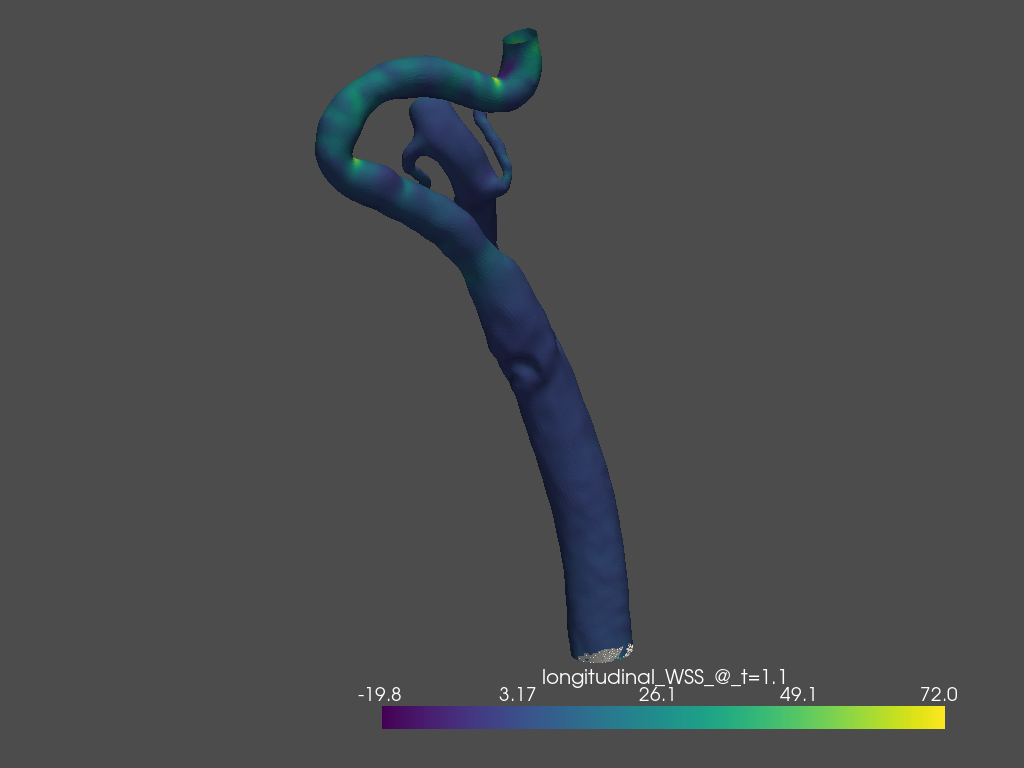

In [44]:
pl = pv.Plotter()
pl.add_mesh(mesh, scalars='longitudinal_WSS_@_t=1.1')
pl.add_points(pointsn, render_points_as_spheres=True, point_size=1.)
pl.show()

In [45]:
mesh.remove_points(nw)

AttributeError: 'UnstructuredGrid' object has no attribute 'remove_points'

In [29]:
mesh.points

pyvista_ndarray([[-37.93020468,  -9.87389993, -41.60447419],
                 [-37.94564958,  -9.86791474, -41.55137475],
                 [-37.97857554,  -9.8345473 , -41.60371369],
                 ...,
                 [-33.57247035, -13.35515718, -48.39478846],
                 [-33.63565021, -13.37436255, -48.47498217],
                 [-33.6030603 , -13.36583697, -48.43542976]])

In [34]:
np.amax(mesh.points, axis=0)

pyvista_ndarray([-11.93719735,  18.44834062, -41.16251321])

In [31]:
mesh.points.shape

(33660, 3)

In [48]:
smesh =mesh.cast_to_explicit_structured_grid()

TypeError: 'BLOCK_I', 'BLOCK_J' and 'BLOCK_K' cell arrays are required

In [49]:
mesh.cell_data.keys()

[]

AttributeError: 'UnstructuredGrid' object has no attribute 'remove_points'

In [55]:
keep_points = np.ones(mesh.points.shape, dtype=bool)
keep_points[nw] = False

In [56]:
new_mesh = pv.UnstructuredGrid(points=mesh.points[keep_points], cells=mesh.cells)

In [58]:
new_mesh.points

pyvista_ndarray([], shape=(0, 3), dtype=float64)